In [ ]:
import yfinance as yf
import pandas as pd
from newsapi import NewsApiClient
from datetime import datetime, timedelta

In [101]:
api_key = 'bafa54c686b64fc08d23017223d25ae2'
newsapi = NewsApiClient(api_key=api_key)

In [102]:
def get_stock_and_news_data(tickers, start_date, end_date):
    all_stock_data = []
    all_news_data = []

    for ticker in tickers:
        # Stock price data
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        stock_data['PriceChange'] = stock_data['Close'].pct_change()
        stock_data = stock_data.dropna()
        stock_data['Movement'] = stock_data['PriceChange'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
        stock_data.index = pd.to_datetime(stock_data.index).date
        stock_data['stock'] = ticker
        all_stock_data.append(stock_data)
        
        # News headlines
        headlines = newsapi.get_everything(q=f'{ticker} stock', from_param=start_date, to=end_date, language='en', sort_by='relevancy', page_size=100)
        
        # Convert news articles to DataFrame
        headlines_df = pd.DataFrame(headlines['articles'])
        headlines_df = headlines_df[headlines_df['title'] != '[Removed]']  # Discard news with title [Removed]
        headlines_df['publishedAt'] = pd.to_datetime(headlines_df['publishedAt']).dt.date
        headlines_df['content'] = headlines_df['content'].fillna('')
        headlines_df['stock'] = ticker
        all_news_data.append(headlines_df)
    
    # Concatenate all dataframes
    stock_df = pd.concat(all_stock_data)
    news_df = pd.concat(all_news_data)
    
    return stock_df, news_df

In [103]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
start_date = "2024-04-25"
end_date = "2024-05-23"

In [104]:
stock_df, news_df = get_stock_and_news_data(tickers, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_6718/2881786239.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Movement'] = stock_data['PriceChange'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_6718/2881786239.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['stock'] = ticker
[*********************100%%*

SSLError: HTTPSConnectionPool(host='newsapi.org', port=443): Max retries exceeded with url: /v2/everything?q=MSFT+stock&from=2024-04-25&to=2024-05-23&language=en&sortBy=relevancy&pageSize=100 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))

---

In [139]:
import pandas as pd
from eodhd import APIClient
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import re

In [147]:
def collect_financial_news(api_key, stock_symbols, from_date, to_date, limit=100):
    client = APIClient(api_key)
    all_news_df = pd.DataFrame()
    
    for symbol in stock_symbols:
        resp = client.financial_news(s=symbol, from_date=from_date, to_date=to_date, limit=limit)
        news_df = pd.DataFrame(resp)
        news_df['symbol'] = symbol  # Aggiungi una colonna per identificare l'azione
        all_news_df = pd.concat([all_news_df, news_df], ignore_index=True)
    
    return all_news_df

In [159]:
def clean_text(text):
    # Rimozione di punteggiatura, ma mantenendo i numeri e i simboli percentuali
    text = re.sub(r'[^\w\s%]', '', text)
    # Conversione in minuscolo
    text = text.lower()
    # Rimozione di spazi extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [160]:
def preprocess_and_analyze_news(news_df):
    # Inizializza l'analizzatore VADER
    vader_analyzer = SentimentIntensityAnalyzer()

    # Pulizia dei titoli delle notizie
    news_df['cleaned_title'] = news_df['title'].apply(clean_text)
    
    # Calcolo del sentiment dei titoli delle notizie usando TextBlob
    news_df['sentiment_textblob'] = news_df['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Calcolo del sentiment dei titoli delle notizie usando VADER
    news_df['sentiment_vader'] = news_df['cleaned_title'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])
    
    # Converti i titoli delle notizie in rappresentazioni TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(news_df['cleaned_title'])
    
    # Aggiungi i sentimenti come caratteristiche aggiuntive
    X = scipy.sparse.hstack((X, news_df[['sentiment_textblob', 'sentiment_vader']].values))
    
    return news_df, X, vectorizer

In [148]:
# Esempio di utilizzo
api_key = '665456c26be9a2.11369205'
stock_symbols = ["AAPL.US", "MSFT.US", "GOOGL.US"]
from_date = '2024-01-01'
to_date = '2024-01-30'

all_news_df = collect_financial_news(api_key, stock_symbols, from_date, to_date)

                        date  \
0  2024-01-30T22:24:05+00:00   
1  2024-01-30T21:29:00+00:00   
2  2024-01-30T21:23:18+00:00   
3  2024-01-30T20:24:00+00:00   
4  2024-01-30T19:56:22+00:00   

                                                                                              title  \
0  Dow Jones Futures: Microsoft, Google, AMD Fall On Earnings; Elon Musk Loses $56 Billion Pay Plan   
1                                              Top Stock Reports for Apple, Visa &amp; Novo Nordisk   
2                                                 3 Must-Watch Stocks Just as Unstoppable as Nvidia   
3                            Apple Stock Sags as Analyst Forecasts Big Drop in iPhone Sales in 2024   
4                       Wall Street Favorites: 3 AI Stocks With Strong Buy Ratings for January 2024   

                                                                                                                                                                                            

In [161]:
news_df, X, vectorizer = preprocess_and_analyze_news(all_news_df)
news_df.head()

,date,title,content,link,symbols,tags,sentiment,symbol,cleaned_title,sentiment_textblob,sentiment_vader
0,2024-01-30T22:24:05+00:00,"Dow Jones Futures: Microsoft, Google, AMD Fall On Earnings; Elon Musk Loses $56 Billion Pay Plan","Microsoft, Google and AMD earnings are a big test for AI, cloud and techs broadly. A judge struck down Elon Musk's huge pay plan.\n\nContinue reading",https://finance.yahoo.com/m/c78e3618-8015-3089-b0cc-fe9c45f6fc2a/dow-jones-futures%3A-microsoft%2C.html,"[0QYP.IL, 0R2V.IL, 0RIH.IL, A1MD34.SA, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN, AAPL.US, AAPL34.SA, ABE0.F, ABEA.F, ABEA.XETRA, ABEC.F, ABEC.STU, ABEC.XETRA, AMD.BE, AMD.DU, AMD.F, AMD.HM]",[],-0.30000000,AAPL.US,dow jones futures microsoft google amd fall on earnings elon musk loses 56 billion pay plan,-0.30000000,-0.40190000
1,2024-01-30T21:29:00+00:00,"Top Stock Reports for Apple, Visa &amp; Novo Nordisk","Tuesday, January 30, 2024\r\n\r\nThe Zacks Research Daily presents the best research output of our analyst team. Today's Research Daily features new research reports on 16 major stocks, including Apple Inc. (AAPL), Visa Inc. (V) and Novo Nordisk A/S (NVO). These research reports have been hand-picked from the roughly 70 reports published by our analyst team today.\r\n\r\nYou can see all of today’s research reports here >>>\r\n\r\nApple’s shares have outperformed the Zacks Computer - Mini computers industry over the past year (+33.6% vs. +33.0%). The company is benefiting from strong demand for the iPhone. Apple expects the iPhone’s year-over-year revenues to grow on an absolute basis in first-quarter fiscal 2024.\r\n\r\nRevenues for Mac are expected to significantly accelerate compared with the fourth-quarter fiscal 2023’s reported figure. It expects the year-over-year revenue growth for both iPad and Wearables, Home and Accessories to decelerate significantly from the September qu...",https://finance.yahoo.com/news/top-stock-reports-apple-visa-212900450.html,"[0R2V.IL, 3V6.F, 3V64.F, 3V64.STU, 3V64.XETRA, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN, AAPL.US, AAPL34.SA, APC.BE, APC.DU, APC.F, APC.HA, APC.HM, APC.MU, APC.STU, APC.XETRA, APC8.F]",[],0.50000000,AAPL.US,top stock reports for apple visa amp novo nordisk,0.50000000,0.20230000
2,2024-01-30T21:23:18+00:00,3 Must-Watch Stocks Just as Unstoppable as Nvidia,"Nvidia (NASDAQ:NVDA) remains one of the hottest stocks in the market right now, with shares eeking out yet another 2.35% gain on Monday’s session. After Nvidia stock’s January jump, shares are flirting with 30% in year-to-date gains. That’s an impressive annual return, let alone one posted in under a month. As to when (or if) shares of the chip giant are bound to reverse course remains the top question on the minds of shareholders and those enjoying the Nvidia show from the sidelines.\n\nSome way or another, NVDA stock has found a way to keep pulling rabbits out of hats, something that could easily continue through 2024. Either way, Nvidia stock remains a dangerous stock to bet against amid its AI tailwind.\n\nThough momentum investors still have lots to love about Nvidia and its latest melt-up, I’d argue it’s worth checking in on other stocks that have already gained traction in recent weeks. Indeed, many such plays may be overheated after their respective rallies. However, each i...",https://finance.yahoo.com/news/3-must-watch-stocks-just-212318924.html,"[0I47.LSE, 0R2L.LSE, AAPL.US, BERK34.SA, BRH.BE, BRH.DU, BRH.F, BRH.HM, BRHF.F, BRK-A.US, BRK-B.US, BRK.NEO, BRKB.MX, BRYN.F, BRYN.XETRA, COST.MX, COST.NEO, COST.US, COWC34.SA]",[],0.00000000,AAPL.US,3 mustwatch stocks just as unstoppable as nvidia,0.00000000,-0.20230000
3,2024-01-30T20:24:00+00:00,Apple Stock Sags as Analyst Forecasts Big Drop in iPhone Sales in 2024,"“Apple may have the most significant decline among the major global phone brands in 2024,” writes Ming-Chi Kuo of TF International Securities..\n\nContinue reading",https://finance.yahoo.com/m/1e001ea3-7d8f-3159-8098-9f56c6dc9f3

In [166]:
def plot_sentiment_distribution(news_df):
    plt.figure(figsize=(12, 6))
    sns.histplot(news_df['sentiment_textblob'], kde=True, color='blue', label='TextBlob')
    sns.histplot(news_df['sentiment_vader'], kde=True, color='green', label='VADER')
    plt.title('Distribuzione dei Sentimenti')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequenza')
    plt.legend()
    plt.show()

In [173]:
def plot_average_sentiment_per_stock(news_df):
    avg_sentiment = news_df.groupby('symbol')[['sentiment_textblob', 'sentiment_vader']].mean().reset_index()
    avg_sentiment = pd.melt(avg_sentiment, id_vars=['symbol'], value_vars=['sentiment_textblob', 'sentiment_vader'], 
                            var_name='Sentiment Type', value_name='Sentiment Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg_sentiment, x='symbol', y='Sentiment Score', hue='Sentiment Type')
    plt.title('Sentimento Medio per Azione')
    plt.xlabel('Azione')
    plt.ylabel('Sentiment Medio')
    plt.legend()
    plt.show()

In [169]:
def plot_sentiment_over_time(news_df, stock_symbols):
    news_df['date'] = pd.to_datetime(news_df['date'])
    
    num_stocks = len(stock_symbols)
    cols = 2
    rows = (num_stocks // cols) + (num_stocks % cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, symbol in enumerate(stock_symbols):
        stock_news = news_df[news_df['symbol'] == symbol].set_index('date')
        stock_news = stock_news[['sentiment_textblob', 'sentiment_vader']].resample('D').mean().reset_index()
        
        axes[i].plot(stock_news['date'], stock_news['sentiment_textblob'], label='TextBlob', color='blue')
        axes[i].plot(stock_news['date'], stock_news['sentiment_vader'], label='VADER', color='green')
        axes[i].set_title(f'Sentiment Over Time for {symbol}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Sentiment')
        axes[i].legend()
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

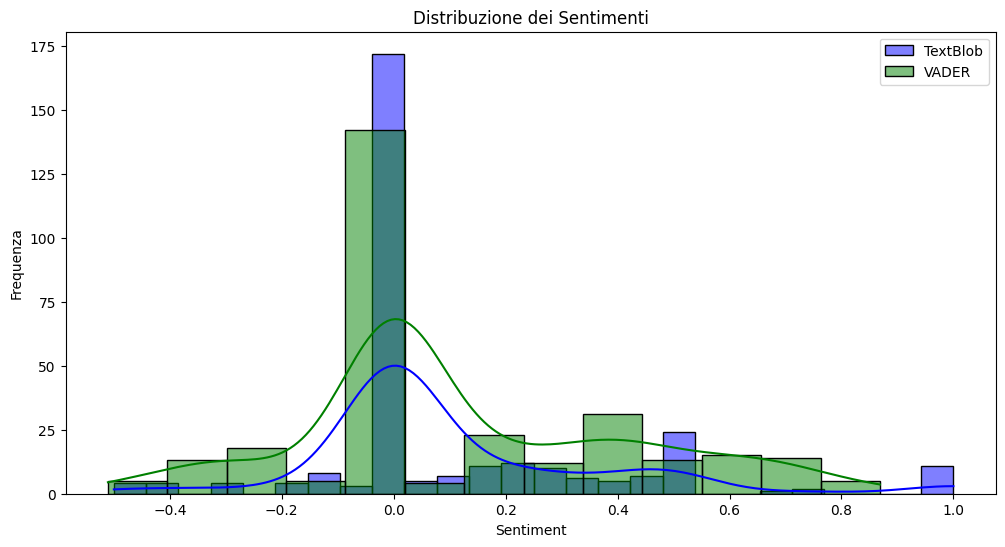

In [171]:
plot_sentiment_distribution(news_df)

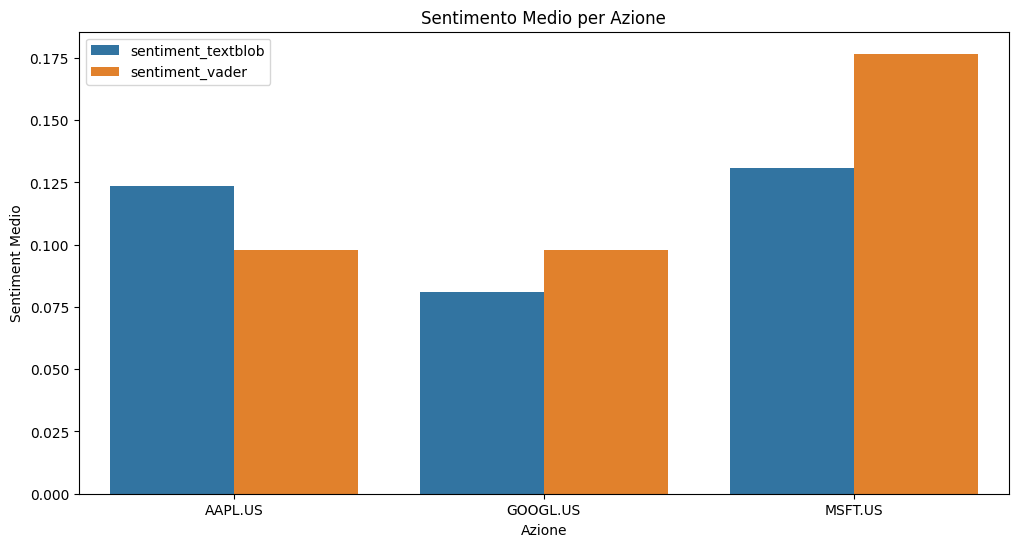

In [172]:
plot_average_sentiment_per_stock(news_df)

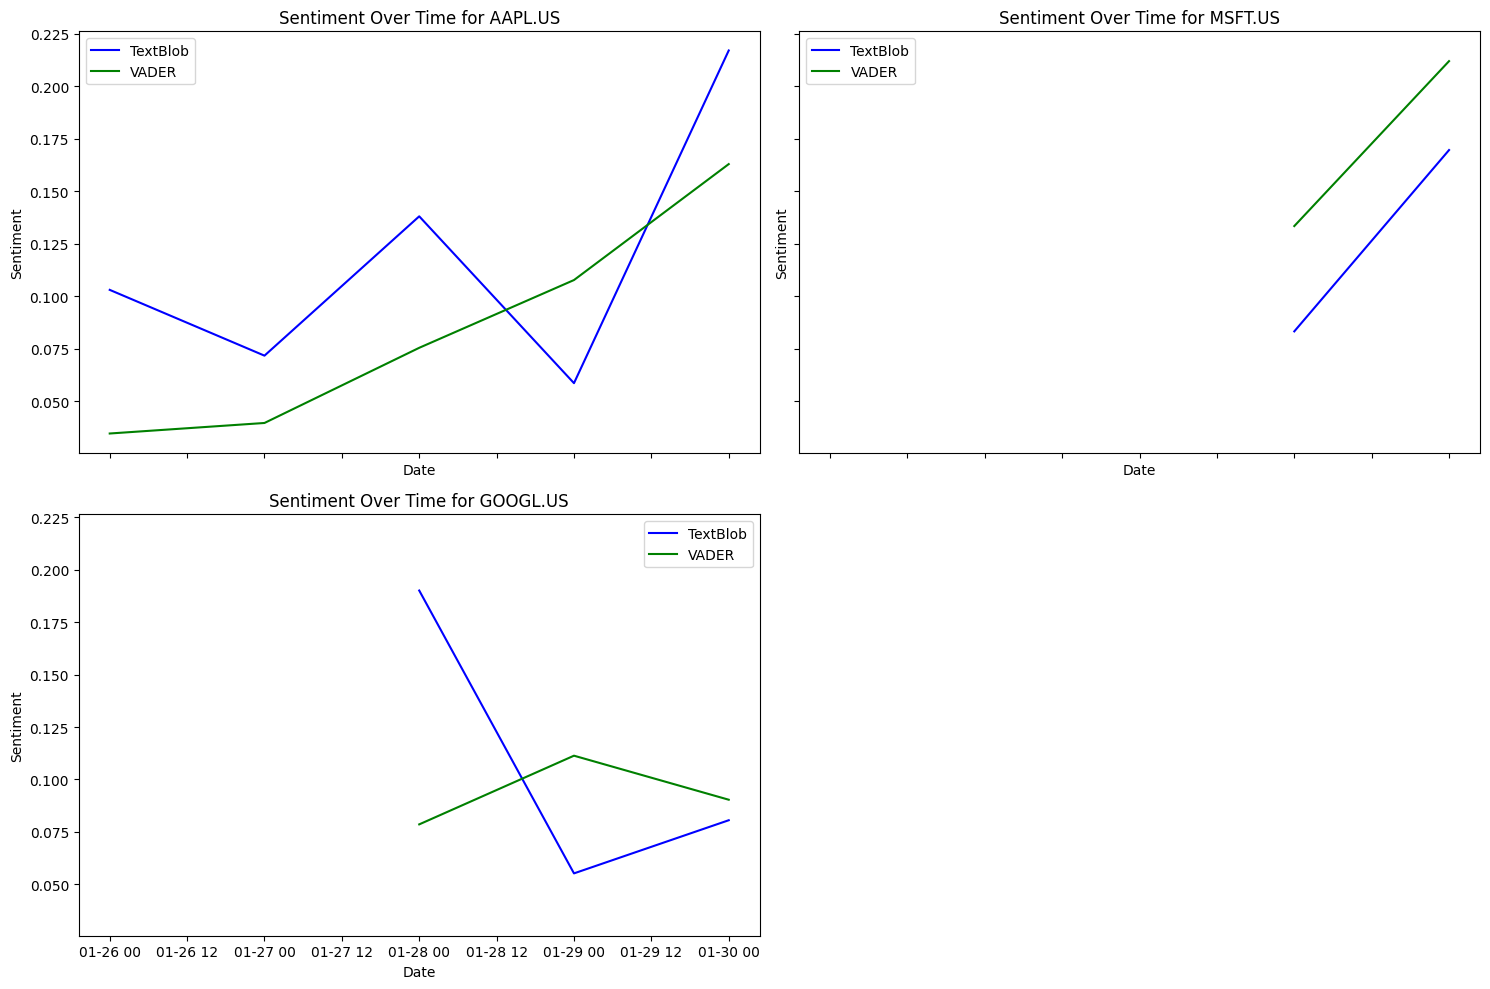

In [170]:
plot_sentiment_over_time(news_df, stock_symbols)